# Section 3: Bayesian Time Series Models

#### PyData London 2025 - Bayesian Time Series Analysis with PyMC

---

In this section, we'll explore the landscape of Bayesian time series models, from simple random walks to sophisticated state-space models and Gaussian processes. These models provide the foundation for understanding temporal patterns and making probabilistic forecasts.

In [1]:
import numpy as np
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings

az.style.use("arviz-darkgrid")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RNG = np.random.default_rng(RANDOM_SEED:=42)

print("🔧 Libraries loaded successfully!")


🔧 Libraries loaded successfully!


Our first motivating example will be the population dymanics of the arctic ground squirrel (*Urocitellus parryii*) in the Kluane region of the Yukon Territory, Canada. Typically, arctic hare get all the attention, with their cyclic population dynamics being a classic example of a predator-prey system. However, the arctic ground squirrel is a more abundant species, and their population dynamics are also interesting.

![Arctic ground squirrel](images/Arctic-Ground-Squirrel.jpg)

Below are densities, estimated independently twice per year from mark-recapture data.

In [2]:
# Load data and filter for years up to 1999
squirrel_data = pl.read_csv('../data/arctic_ground_squirrels_timeseries.csv')

# Create plot data with both spring and summer for context
squirrel_plot = (squirrel_data
    .filter(pl.col('Average_per_ha').is_not_null())
    .filter(pl.col('Year') <= 1999)
    .sort(['Year', 'Season'])
    .with_columns([
        pl.when(pl.col('Season') == 'Spring')
        .then(pl.col('Year') + 0.25)
        .otherwise(pl.col('Year') + 0.5)
        .alias('Year_fractional')
    ])
)

In [3]:
# Create marker colors and symbols based on season
marker_colors = ['green' if season == 'Spring' else 'orange' for season in squirrel_plot['Season']]
marker_symbols = ['circle' if season == 'Spring' else 'square' for season in squirrel_plot['Season']]
hover_text = [f'<b>Year:</b> {year:.0f}<br><b>Season:</b> {season}<br><b>Density:</b> {density:.2f} per hectare<extra></extra>' 
              for year, season, density in zip(squirrel_plot['Year_fractional'], squirrel_plot['Season'], squirrel_plot['Average_per_ha'])]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=squirrel_plot['Year_fractional'],
    y=squirrel_plot['Average_per_ha'],
    mode='lines+markers',
    name='Population Density',
    line=dict(color='steelblue', width=2),
    marker=dict(
        size=8,
        color=marker_colors,
        symbol=marker_symbols
    ),
    text=squirrel_plot['Season'],
    hovertemplate=hover_text
))

fig.update_layout(
    title=dict(
        text='Arctic Ground Squirrel Population Density - Spring and Summer (1990-1999)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    showlegend=False,
    template='plotly_white'
)

fig.add_annotation(
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    text='🟢 Spring &nbsp;&nbsp; 🟠 Summer',
    showarrow=False,
    font=dict(size=12),
    bgcolor='rgba(255,255,255,0.8)',
    bordercolor='gray',
    borderwidth=1
)

fig.show()

## Random Walk Models

The regression model that we fit in the previous notebook assumes a linear relationship between predictor and response variables. This is a parametric regression - it uses just a few parameters (slope and intercept) to describe the entire relationship.

In contrast, **non-parametric models** use many parameters to flexibly adapt to the data's structure without imposing strong assumptions about functional form. They aren't actually without parameters; rather, the number of parameters varies with the quantity of data.

We'll demonstrate this flexibility using a random walk, where each observation depends only on the previous value plus random noise:

$$y_t = y_{t-1} + \epsilon_t$$

Here, $\epsilon_t$ represents the **innovation** or step size, which is drawn from a probability distribution at each time point $t$.

### Gaussian Random Walk

A **Gaussian Random Walk** is a specific flavor of random walk where the innovations are Gaussian, $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$.

This structure allows random walks to adapt to various trend patterns without imposing rigid functional forms. Moreover, the variance of the random walk is non-stationary, reflecting our decreasing confidence in long-term predictions. 

$\text{Var}(y_t) = t \cdot \sigma^2$

### State-Space Approach

In our implementation, we are going to separate the **latent random walk process** from the **observation process**, creating a state-space structure:

**State equation**: $x_t = x_{t-1} + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, \sigma_{\text{walk}}^2)$

**Observation equation**: $y_t = x_t + \nu_t$ where $\nu_t \sim \mathcal{N}(0, \sigma_{\text{obs}}^2)$

This separation allows us to distinguish between **process noise** (how much the underlying state changes) and **measurement noise** (how much error exists in our observations).

Let's implement a Gaussian random walk in PyMC to model the Arctic ground squirrel population data. To keep things simple, we will only model the summer population.

In [4]:
# Extract summer data only for modeling
squirrel_summer = (squirrel_data
    .filter(pl.col('Average_per_ha').is_not_null())
    .filter(pl.col('Season') == 'Summer')
    .filter(pl.col('Year') <= 1999)
    .sort('Year')
    .with_row_index('time_index')
)

# Model variables (summer data only)
squirrel_density = squirrel_summer['Average_per_ha'].to_numpy()
years = squirrel_summer['Year'].to_numpy().astype(int)
n_years = len(years)
time_idx = np.arange(n_years)
time_normalized = (time_idx - time_idx.mean()) / time_idx.std()

In [5]:
# Simple Random Walk for Ground Squirrel Summer Population
with pm.Model(coords={'time': years}) as simple_rw_model:
    
    # Step size of the random walk (innovation standard deviation)
    sigma_walk = pm.HalfNormal('sigma_walk', sigma=1.0)
    
    # Initial value distribution
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    
    # Gaussian random walk process using dims
    log_walk = pm.GaussianRandomWalk('log_walk', 
        mu=0,  # no drift
        sigma=sigma_walk, 
        init_dist=init_dist,
        dims='time')
    
    walk = pm.Deterministic('walk', pm.math.exp(log_walk))
    
    # Observation noise (measurement error)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    
    # Likelihood: observed squirrel density data are noisy observations of the walk
    y = pm.LogNormal('y', mu=log_walk, sigma=sigma_obs, observed=squirrel_density, dims='time')

In [6]:
with simple_rw_model:
    trace_simple_rw = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_walk, log_walk, sigma_obs]


Output()

ConnectionResetError: [Errno 104] Connection reset by peer

In [ ]:
print("🎯 **Simple Random Walk Results for Ground Squirrel Summer Population**:")
print(az.summary(trace_simple_rw, var_names=['sigma_walk', 'sigma_obs']))

🎯 **Simple Random Walk Results for Ground Squirrel Summer Population**:
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_walk  0.347  0.166   0.043    0.611      0.008    0.004     283.0   
sigma_obs   0.229  0.152   0.028    0.480      0.011    0.004     137.0   

            ess_tail  r_hat  
sigma_walk     183.0   1.01  
sigma_obs      145.0   1.03  


In [ ]:
with simple_rw_model:
    pm.sample_posterior_predictive(trace_simple_rw, extend_inferencedata=True,
                                   random_seed=RANDOM_SEED)

Sampling: [y]


Output()

In [ ]:
walk_samples = az.extract(trace_simple_rw)['walk']
y_samples = az.extract(trace_simple_rw, group='posterior_predictive')['y']

walk_mean = walk_samples.mean(dim='sample')
walk_hdi = az.hdi(trace_simple_rw, var_names=['walk'])['walk']

y_mean = y_samples.mean(dim='sample')
y_hdi = az.hdi(trace_simple_rw, group='posterior_predictive', var_names=['y'])['y']

go.Figure().add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([y_hdi[:, 1], y_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(144, 238, 144, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Posterior Predictive 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([walk_hdi[:, 1], walk_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=years,
    y=walk_mean,
    mode='lines',
    name='Estimated Random Walk',
    line=dict(color='darkgreen', width=3)
)).add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
)).update_layout(
    title=dict(
        text='Simple Random Walk Model - Arctic Ground Squirrel Summer Population',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

### Forecasting with Random Walk Models

One of the key advantages of Bayesian time series models is their ability to generate **probabilistic forecasts** that naturally quantify uncertainty. For random walk models, forecasting involves extending the stochastic process beyond the observed data.

**Mathematical Foundation of Random Walk Forecasting**:

For a random walk $y_t = y_{t-1} + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$, the **h-step ahead forecast** from time $T$ is:

$$\hat{y}_{T+h|T} = y_T$$

The **forecast variance** grows linearly with the forecast horizon:

$$\text{Var}(y_{T+h|T}) = h \cdot \sigma^2$$

This means that:
- **Point forecasts** remain constant at the last observed value
- **Prediction intervals** widen linearly with time, reflecting increasing uncertainty
- **Long-term forecasts** become highly uncertain, which is realistic for many natural processes

Let's generate 10-year forecasts (2000-2009) for the Arctic ground squirrel population using parameters from our fitted random walk model.

In [ ]:
# Define forecast years (2000-2009)
forecast_years = np.arange(2000, 2010)
n_forecast = len(forecast_years)

posterior = az.extract(trace_simple_rw)
log_walk_samples = posterior['log_walk'].to_numpy()  
sigma_walk_samples = posterior['sigma_walk'].to_numpy()
sigma_obs_samples = posterior['sigma_obs'].to_numpy()

final_log_state_samples = log_walk_samples[-1, :]
n_samples = len(final_log_state_samples)

random_steps = np.random.normal(
    loc=0, 
    scale=sigma_walk_samples[:, np.newaxis], 
    size=(n_samples, n_forecast)
)

# Create the random walks using cumulative sum
future_increments = np.cumsum(random_steps, axis=1)

future_log_means = final_log_state_samples[:, np.newaxis] + future_increments

Z = np.random.normal(0, 1, size=(n_samples, n_forecast))

future_trajectories = np.exp(future_log_means + sigma_obs_samples[:, np.newaxis] * Z)

rw_forecast_median = np.median(future_trajectories, axis=0)
rw_forecast_hdi = az.hdi(future_trajectories, hdi_prob=0.95)
rw_forecast_lower = rw_forecast_hdi[:, 0]
rw_forecast_upper = rw_forecast_hdi[:, 1]

go.Figure().add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
)).add_trace(go.Scatter(
    x=forecast_years,
    y=rw_forecast_median,
    mode='lines',
    name='Forecast Median',
    line=dict(color='blue', width=3)
)).add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([rw_forecast_upper, rw_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% HDI',
    showlegend=True
)).update_layout(
    title=dict(
        text='10-Year Forecast for Arctic Ground Squirrel Summer Population (2000-2009)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
).update_yaxes(range=[0, None])

**Key Mathematical Properties**:

- **Stationarity condition**: $|\rho| < 1$ ensures the process is stationary
- **Mean**: $\mathbb{E}[y_t] = 0$ (assuming zero mean)
- **Variance**: $\text{Var}(y_t) = \frac{\sigma^2}{1 - \rho^2}$ (constant for stationary process)
- **Autocorrelation**: $\rho(k) = \rho^k$ (exponential decay)

**Interpretation of $\rho$**:
- $\rho > 0$: **Positive persistence** - high values tend to be followed by high values
- $\rho < 0$: **Oscillatory behavior** - high values tend to be followed by low values
- $\rho \approx 1$: **Near unit root** - very persistent, close to random walk behavior
- $\rho = 0$: **White noise** - no temporal dependence


### Interpreting Random Walk Forecasts

The forecast visualization reveals several key characteristics of random walk predictions:

**Forecast Behavior**:
- **Constant median prediction**: The forecast median remains approximately at the last observed value (though the mean is increasing)
- **Linearly increasing uncertainty**: The prediction intervals widen steadily over time, reflecting the accumulating uncertainty inherent in random walk processes
- **Realistic long-term uncertainty**: By 2009, the 95% HDI spans a wide range, acknowledging our limited ability to predict population levels a decade ahead

While the projections may not be terribly useful, it does at least provide a accurate reflection of its uncertainty, given the simplicity of the projection methodology. We probably need to incorporate covariates or other processes to improve the projections.

### Autoregressive Model AR(1)

**Autoregressive models** capture temporal dependence by relating current observations to past observations. An **AR(1) model** is defined as:

$$y_t = \phi y_{t-1} + \epsilon_t$$

where $\phi$ is the **autoregressive coefficient** and $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ is white noise.

A Gaussian random walk is a special case of an **autoregressive model**, where $\phi = 1$.

Now let's consider the more general case where $\rho$ varies.

In [ ]:
# AR(1) for Ground Squirrel Summer Population
with pm.Model(coords={'time': years}) as ar1_model:
    
    sigma_ar = pm.HalfNormal('sigma_ar', sigma=1.0)

    # AR coefficient
    rho = pm.Normal('rho', mu=0, sigma=1.0)
    
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    
    log_ar = pm.AR('log_ar', 
        rho=rho,
        sigma=sigma_ar,
        init_dist=init_dist,
        dims='time')
    
    ar = pm.Deterministic('ar', pm.math.exp(log_ar))
    
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, observed=squirrel_density, dims='time')

In [ ]:
with ar1_model:
    trace_ar1 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
    pm.sample_posterior_predictive(trace_ar1, extend_inferencedata=True,
                                   random_seed=RANDOM_SEED)
    
print("🎯 **AR(1) Model Results for Ground Squirrel Population**:")
print(az.summary(trace_ar1, var_names=['rho', 'sigma_ar']))

# Extract and interpret AR coefficient
rho_mean = az.extract(trace_ar1)['rho'].mean().item()
rho_hdi = az.hdi(trace_ar1, var_names=['rho'])['rho']

print("\n📈 **Population Persistence Analysis**:")
print(f"   • **AR coefficient (φ)**: {rho_mean:.3f}")
print(f"   • **95% HDI**: [{rho_hdi.sel(hdi='lower').item():.3f}, {rho_hdi.sel(hdi='higher').item():.3f}]")
if rho_mean > 0.5:
    print("   • **Ecological interpretation**: High population persistence - good years tend to follow good years")
elif rho_mean < -0.5:
    print("   • **Ecological interpretation**: Population oscillations - good years tend to follow bad years")
else:
    print("   • **Ecological interpretation**: Moderate population memory - some year-to-year correlation")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_ar, rho, log_ar, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

🎯 **AR(1) Model Results for Ground Squirrel Population**:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
rho       0.316  0.443  -0.629    1.039      0.021    0.009     444.0   
sigma_ar  0.328  0.160   0.047    0.606      0.006    0.004     510.0   

          ess_tail  r_hat  
rho         1652.0   1.02  
sigma_ar     502.0   1.01  

📈 **Population Persistence Analysis**:
   • **AR coefficient (φ)**: 0.316
   • **95% HDI**: [-0.629, 1.039]
   • **Ecological interpretation**: Moderate population memory - some year-to-year correlation


**Key Mathematical Properties**:

- **Stationarity condition**: $|\rho| < 1$ ensures the process is stationary
- **Mean**: $\mathbb{E}[y_t] = 0$ (assuming zero mean)
- **Variance**: $\text{Var}(y_t) = \frac{\sigma^2}{1 - \rho^2}$ (constant for stationary process)
- **Autocorrelation**: $\rho(k) = \rho^k$ (exponential decay)

**Interpretation of $\rho$**:
- $\rho > 0$: **Positive persistence** - high values tend to be followed by high values
- $\rho < 0$: **Oscillatory behavior** - high values tend to be followed by low values
- $\rho \approx 1$: **Near unit root** - very persistent, close to random walk behavior
- $\rho = 0$: **White noise** - no temporal dependence


In [ ]:
ar_samples = az.extract(trace_ar1)['ar']
y_samples = az.extract(trace_ar1, group='posterior_predictive')['y']

ar_mean = ar_samples.mean(dim='sample')
ar_hdi = az.hdi(trace_ar1, var_names=['ar'])['ar']

y_mean = y_samples.mean(dim='sample')
y_hdi = az.hdi(trace_ar1, group='posterior_predictive', var_names=['y'])['y']

go.Figure().add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([y_hdi[:, 1], y_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(144, 238, 144, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Posterior Predictive 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([walk_hdi[:, 1], walk_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI',
    showlegend=True
)).add_trace(go.Scatter(
    x=years,
    y=walk_mean,
    mode='lines',
    name='Estimated Density',
    line=dict(color='darkgreen', width=3)
)).add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
)).update_layout(
    title=dict(
        text='AR(1) Model - Arctic Ground Squirrel Summer Population',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

<Axes: title={'center': 'rho'}>

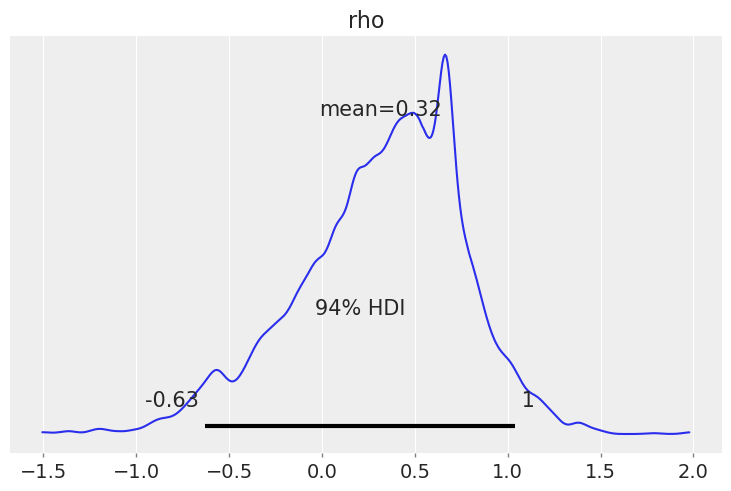

In [ ]:
az.plot_posterior(trace_ar1, var_names=['rho'])

## Extending to AR(2) Models

While the AR(1) model provides a flexible generalization to the random walk, ecological systems often exhibit more complex dynamics that span multiple time periods. For example, an AR(2) model extends our analysis by incorporating dependencies on two previous time steps:

$$\log(y_t) = \rho_1 \cdot \log(y_{t-1}) + \rho_2 \cdot \log(y_{t-2}) + \epsilon_t$$

Where:
- $\rho_1$ represents the immediate persistence effect (as in AR(1))
- $\rho_2$ captures delayed effects from two time steps ago
- $\epsilon_t$ is the innovation term (random shock)

In the context of this data, AR(2) models can reveal important ecological patterns:

1. **Cyclical Dynamics**: Negative values of $\rho_2$ often indicate cyclical population fluctuations
2. **Delayed Density Dependence**: Effects of population size may take multiple years to manifest
3. **Complex Environmental Responses**: Populations may respond to environmental conditions with lag effects

Let's see how an AR(2) model performs on our squirrel data.

In [ ]:
# AR(2) Model
with pm.Model(coords={'time': years, 'lag': ['lag1', 'lag2']}) as ar2_model:
    
    sigma_ar = pm.HalfNormal('sigma_ar', sigma=1.0)

    rho = pm.Normal('rho', mu=0, sigma=1.0, shape=2, dims='lag')
    
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    
    log_ar = pm.AR('log_ar', 
        rho=rho,
        sigma=sigma_ar,
        init_dist=init_dist,
        dims='time')
    
    ar = pm.Deterministic('ar', pm.math.exp(log_ar), dims='time')
    
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, observed=squirrel_density, dims='time')

    trace_ar2 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_ar, rho, log_ar, sigma_obs]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'rho\nlag1'}>,
       <Axes: title={'center': 'rho\nlag2'}>], dtype=object)

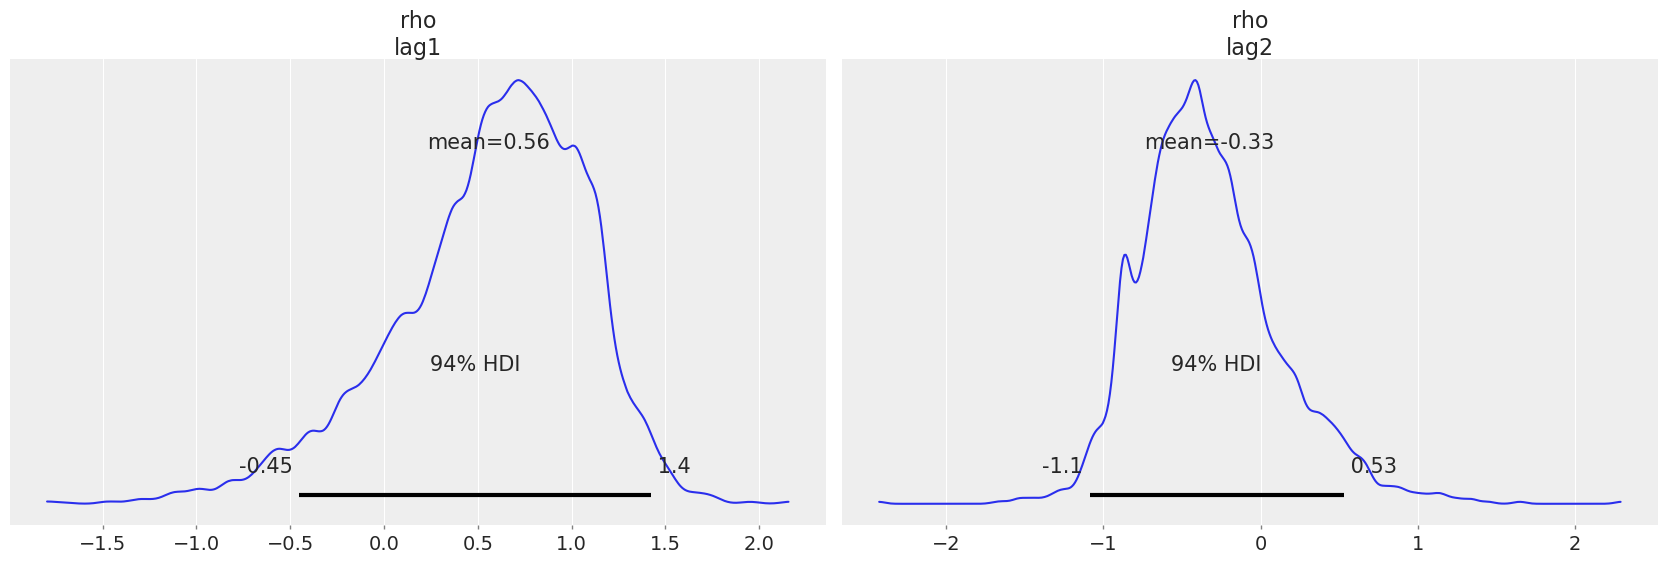

In [ ]:
az.plot_posterior(trace_ar2, var_names=['rho'])

The estimated lag-2 autoregressive coefficient is probably negative, though it overlaps zero to some degree. This may be capturing a little of the cyclic behavior in the data.

Let's take this model and generate predictions, and compare them to what the population actually did post-2000.

### Forecasting with a Dummy Model

While it is easy to manually generate random walk projections, its a little more complicated for and autoregressive model. So, we will use PyMC's sampling machinery to do this for us.

First, we will create a new model for forecasting. We will use the parameters from the fitted model and use them to generate predictive samples for future years.

To reiterate, we use a *new* model object, but with the future seasons as the time coordinate. Then we create "dummy" variables for the parameters:

In [ ]:
# Create a new model for forecasting
with pm.Model(coords={'time': forecast_years}) as forecast_model:

    # Get parameters from the fitted model
    sigma_ar = pm.Flat('sigma_ar')
    rho = pm.Flat('rho', shape=2)
    sigma_obs = pm.Flat('sigma_obs')

Why are we doing this? Becuase we will be using the samples from the *fitted* model for these parameters; these `Flat` variables are just placeholders!

Next, we will grab the last two time periods from the fitted model and use them to initialize the forecasting AR process. 

The `DiracDelta` distribution is a way of specifying a variable that is essentially a constant. These initial values are then passed to a new AR(2) process, which is defined for the forecast period.

In [ ]:
with forecast_model:
    
    # Get the last two values from the fitted model to initialize the forecast
    log_ar_last = trace_ar2.posterior['log_ar'].mean(dim=['chain', 'draw'])[-2:].values
    
    # Create AR(2) process for the entire time period
    init_dist = pm.DiracDelta.dist(log_ar_last)
    log_ar = pm.AR('log_ar', rho=rho, sigma=sigma_ar, init_dist=init_dist, dims='time')

The rest of the model is pretty much the same as the orignal model. The key difference is that we only do **posterior predictive sampling** -- we are not fitting a new model.

In [ ]:
with forecast_model:
    
    # Transform to original scale
    ar = pm.math.exp(log_ar)
    
    # Likelihood for the observed period
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, dims='time')

    # Sample from posterior predictive
    ar2_forecast_trace = pm.sample_posterior_predictive(
        trace_ar2, 
        var_names=['y'], 
        random_seed=RANDOM_SEED
    )

Sampling: [log_ar, y]


Output()

Let's take a look at the projections:

In [ ]:

ar2_forecast_samples = ar2_forecast_trace.posterior_predictive['y'].stack(sample=("chain", "draw"))
ar2_forecast_median = ar2_forecast_samples.median(dim='sample').values
ar2_forecast_lower = np.zeros(n_forecast)
ar2_forecast_upper = np.zeros(n_forecast)
ar2_forecast_values = ar2_forecast_samples.values[-n_forecast:]

for t in range(n_forecast):
    hdi = az.hdi(ar2_forecast_values[t], hdi_prob=0.95)
    ar2_forecast_lower[t] = hdi[0]
    ar2_forecast_upper[t] = hdi[1]

actual_future = (squirrel_data
    .filter((pl.col('Year') >= 2000) & (pl.col('Year') <= 2009) & (pl.col('Season') == 'Summer'))
    .sort('Year')
)
actual_years = actual_future['Year'].to_numpy()
actual_density = actual_future['Average_per_ha'].to_numpy()

go.Figure().add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
)).add_trace(go.Scatter(
    x=forecast_years,
    y=ar2_forecast_median[-n_forecast:],
    mode='lines',
    name='Forecast Median',
    line=dict(color='blue', width=3)
)).add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([ar2_forecast_upper, ar2_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% HDI',
    showlegend=True
)).update_layout(
    title=dict(
        text='10-Year Forecast for Arctic Ground Squirrel Summer Population (2000-2009)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
).update_yaxes(range=[0, None])

The uncertainty in the AR(2) process appears dampened relative to the random walk, likely because of both the lag-one autocorrelation being smaller than 1 and the slight negative autocorrelation in the second lag. 

Here is a prior predictive sample from such a model:

In [ ]:
# Generate prior predicitve samples from an AR2 process with rho fixed to (0.5, -0.3)
n_years = 30

with pm.Model() as prior_model:
            
    init_dist = pm.Normal.dist(mu=0, sigma=0.1, shape=2)
    
    log_ar = pm.AR('log_ar', 
        rho=[0.5, -0.3],
        sigma=0.1,
        init_dist=init_dist,
        steps=n_years
    )
    
    ar = pm.Deterministic('ar', pt.exp(log_ar))
    
    trace_prior = pm.sample_prior_predictive(1000, random_seed=RANDOM_SEED)

# Extract prior samples for visualization
prior_samples = az.extract(trace_prior, group="prior")['ar']

# Calculate median
prior_median = prior_samples.median(dim='sample')

# Calculate HDI properly for each time point
time_points = np.arange(n_years)
prior_hdi_lower = np.zeros(n_years)
prior_hdi_upper = np.zeros(n_years)

for i in range(n_years):
    hdi_interval = az.hdi(prior_samples[i, :].values, hdi_prob=0.95)
    prior_hdi_lower[i] = hdi_interval[0]
    prior_hdi_upper[i] = hdi_interval[1]

go.Figure().add_trace(go.Scatter(
    x=time_points,
    y=prior_median,
    mode='lines',
    name='Prior Median',
    line=dict(color='darkblue', width=3)
)).add_trace(go.Scatter(
    x=np.concatenate([time_points, time_points[::-1]]),
    y=np.concatenate([prior_hdi_upper, prior_hdi_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Prior 95% HDI',
    showlegend=True
)).update_layout(
    title="Prior Predictive Distribution for AR(2) Process",
    xaxis_title="Time Step",
    yaxis_title="Value",
    template="plotly_white"
)

Sampling: [log_ar]


Thus, despite the fact that the random walk and autoregressive models modeled the past states very similarly ...

In [ ]:
ar_mean = az.extract(trace_ar2)['ar'].mean(dim='sample')
ar_hdi = az.hdi(trace_ar2, var_names=['ar'])['ar']

go.Figure().add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='black',
        symbol='circle'
    )
)).add_trace(go.Scatter(
    x=years,
    y=walk_mean,
    mode='lines',
    name='Random Walk Mean',
    line=dict(color='darkgreen', width=3)
)).add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([walk_hdi[:, 1], walk_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI'
)).add_trace(go.Scatter(
    x=years,
    y=ar_mean,
    mode='lines',
    name='AR(2) Mean',
    line=dict(color='darkblue', width=3)
)).add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([ar_hdi[:, 1], ar_hdi[::-1, 0]]),
    fill='toself',
    fillcolor='rgba(30, 144, 255, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='AR(2) 95% HDI'
)).update_layout(
    title=dict(
        text='Model Comparison: Random Walk vs AR(2) for Squirrel Population',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

... the projections end up being quite different.

In [ ]:
# Create a new model for forecasting
with pm.Model(coords={'time': forecast_years}) as forecast_model:

    # Get parameters from the fitted model
    sigma_ar = pm.Flat('sigma_ar')
    rho = pm.Flat('rho', shape=2)
    sigma_obs = pm.Flat('sigma_obs')
    
    # Get the last two values from the fitted model to initialize the forecast
    log_ar_last = trace_ar2.posterior['log_ar'].mean(dim=['chain', 'draw'])[-2:].values
    
    # Create AR(2) process for the entire time period
    init_dist = pm.DiracDelta.dist(log_ar_last)
    log_ar = pm.AR('log_ar', rho=rho, sigma=sigma_ar, init_dist=init_dist, dims='time')
    
    # Transform to original scale
    ar = pm.math.exp(log_ar)
    
    # Likelihood for the observed period
    y = pm.LogNormal('y', mu=log_ar, sigma=sigma_obs, dims='time')

    
    # Sample from posterior predictive
    ar2_forecast_trace = pm.sample_posterior_predictive(
        trace_ar2, 
        var_names=['y'], 
        random_seed=RANDOM_SEED
    )

ar2_forecast_samples = ar2_forecast_trace.posterior_predictive['y'].stack(sample=("chain", "draw"))
ar2_forecast_median = ar2_forecast_samples.median(dim='sample').values

# Calculate HDI manually for each time point
ar2_forecast_lower = np.zeros(n_forecast)
ar2_forecast_upper = np.zeros(n_forecast)

# Get only the forecast period values (last n_forecast values
ar2_forecast_values = ar2_forecast_samples.values[-n_forecast:]

# Calculate HDI for each time point separately
for t in range(n_forecast):
    hdi = az.hdi(ar2_forecast_values[t], hdi_prob=0.95)
    ar2_forecast_lower[t] = hdi[0]
    ar2_forecast_upper[t] = hdi[1]

# Extract actual observations for the forecast period (summer only)
actual_future = (squirrel_data
    .filter((pl.col('Year') >= 2000) & (pl.col('Year') <= 2009) & (pl.col('Season') == 'Summer'))
    .sort('Year')
)
actual_years = actual_future['Year'].to_numpy()
actual_density = actual_future['Average_per_ha'].to_numpy()

# Create the forecast plot
fig = go.Figure()

# Add original data points (1990-1999)
fig.add_trace(go.Scatter(
    x=years,
    y=squirrel_density,
    mode='markers',
    name='Observed Data',
    marker=dict(
        size=8,
        color='red',
        symbol='circle',
        line=dict(width=2, color='darkred')
    )
))

# Add test data points (2000-2009)
# Add test data points (2000-2009) - hidden by default but toggleable
fig.add_trace(go.Scatter(
    x=actual_years,
    y=actual_density,
    mode='markers',
    name='Test Data',
    marker=dict(
        size=8,
        color='green',
        symbol='circle',
        line=dict(width=2, color='darkgreen')
    ),
    visible='legendonly'  # Hidden by default, can be toggled via legend
))

# Add AR(2) median forecast line
fig.add_trace(go.Scatter(
    x=forecast_years,
    y=ar2_forecast_median[-n_forecast:],
    mode='lines',
    name='AR(2) Forecast',
    line=dict(color='blue', width=3)
))

# Add AR(2) 95% HDI as a shaded region
fig.add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([ar2_forecast_upper, ar2_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='AR(2) 95% HDI',
    showlegend=True
))

# Add Random Walk median forecast line
fig.add_trace(go.Scatter(
    x=forecast_years,
    y=rw_forecast_median,
    mode='lines',
    name='Random Walk Forecast',
    line=dict(color='purple', width=3, dash='dash')
))

# Add Random Walk 95% HDI as a shaded region
fig.add_trace(go.Scatter(
    x=np.concatenate([forecast_years, forecast_years[::-1]]),
    y=np.concatenate([rw_forecast_upper, rw_forecast_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(128, 0, 128, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Random Walk 95% HDI',
    showlegend=True
))

# Update layout
fig.update_layout(
    title=dict(
        text='10-Year Forecast Comparison: AR(2) vs Random Walk (2000-2009)',
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title='Year',
    yaxis_title='Population Density (per hectare)',
    width=900,
    height=500,
    template='plotly_white',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

# Ensure y-axis doesn't go below zero for population density
fig.update_yaxes(range=[0, None])

fig.show()

Sampling: [log_ar, y]


Output()

By the years 2000-2001, the population density had crashed to levels approaching zero. This near-zero density (consistently below 0.25 individuals per hectare and often indistinguishable from zero on the graph) persisted for the remainder of the observation period, extending to 2016. This pattern signifies not merely a cyclical low but a sustained population collapse with no apparent recovery for over 15 years. 

The evidence strongly indicates that this was not due to a single cause but rather a synergistic interaction of several factors. The primary driver appears to have been intensified predation pressure, which became particularly acute following the 1998 snowshoe hare population peak and was sustained by a subsequent attenuation of the hare cycle. This led to ground squirrel populations being driven into, and held within, a "predator pit."

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 05 2025

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.1.0

pymc    : 5.22.0
plotly  : 6.0.1
numpy   : 2.2.5
pytensor: 2.30.3
polars  : 1.27.1
arviz   : 0.21.0

Watermark: 2.5.0

